In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmadbarraj","key":"f7e90e159e5aa94ab43549ef0068a85f"}'}

Download Dataset from Kaggle

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d adityajn105/flickr8k



Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [3]:
!unzip flickr8k.zip -d /content/flickr8k

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr8k/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/flickr8k/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/flickr8k/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/flickr8k/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/flickr8k/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/flickr8k/Images/2846037553_1a1de50709.jpg  
  inflating: /content/flickr8k/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/flickr8k/Images/2846843520_b0e6211478.jpg  
  inflating: /content/flickr8k/Images/2847514745_9a35493023.jpg  
  inflating: /content/flickr8k/Images/2847615962_c330bded6e.jpg  
  inflating: /content/flickr8k/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/flickr8k/Images/2848266893_9693c66275.jpg  
  inflating: /content/flickr8k/Images/2848571082_26454cb981.jpg  
  inflating: /content/flickr8k/Images/2848895544_6d06210e9d.jpg  
  inflating: /content/fli

In [2]:
import os

# List the files in the directory to check if the images are there
images_path = '/content/flickr8k/Images/'
print(os.listdir(images_path)[:10])  # Display the first 10 files


['3537201804_ce07aff237.jpg', '3229282764_a4a515f4e2.jpg', '2456030728_d3d147e774.jpg', '468608014_09fd20eb9b.jpg', '823697339_aadbeef495.jpg', '3396251819_1efa69310f.jpg', '2622517932_57c52c376f.jpg', '324208502_674488bcea.jpg', '2467850190_07a74d89b7.jpg', '2211593099_4a4f1c85d2.jpg']


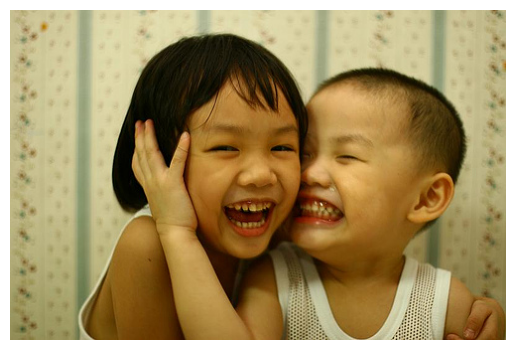

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = '/content/flickr8k/Images/2886837407_a4510ab1ef.jpg'

try:
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
except FileNotFoundError:
    print("File not found. Please check the path.")


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array, array_to_img

import numpy as np
import pickle
from PIL import Image, UnidentifiedImageError

Data Preparation and Preprocessing

In [4]:
def load_caption_file(path):
    captions_dict = {}

    for caption in open(path):
        # Split line into image name and the caption part
        tokens = caption.strip().split()
        img_id_with_caption_num = tokens[0]  # e.g., "1000268201_693b08cb0e.jpg#0"
        img_id = img_id_with_caption_num.split('#')[0].split('.')[0]  # remove .jpg and #index
        caption_text = ' '.join(tokens[1:])  # rest is the actual caption

        # Append captions to the list
        if img_id not in captions_dict:
            captions_dict[img_id] = [caption_text]
        else:
            captions_dict[img_id].append(caption_text)

    return captions_dict
captions_path = '/content/flickr8k/captions.txt'
captions_dict = load_caption_file(captions_path)

In [8]:
from collections import Counter

# Count how many captions each image has
caption_lengths = [len(captions) for captions in captions_dict.values()]

# Count frequency of each caption count
length_distribution = Counter(caption_lengths)

print("📊 Caption count distribution per image:")
for count, num_images in sorted(length_distribution.items()):
    print(f"{num_images} images have {count} captions")


📊 Caption count distribution per image:
1 images have 1 captions
8091 images have 5 captions


In [5]:
# Remove images with fewer than 2 captions
captions_dict = {img_id: caps for img_id, caps in captions_dict.items() if len(caps) > 1}


In [10]:
from collections import Counter

# Count how many captions each image has
caption_lengths = [len(captions) for captions in captions_dict.values()]

# Count frequency of each caption count
length_distribution = Counter(caption_lengths)

print("📊 Caption count distribution per image:")
for count, num_images in sorted(length_distribution.items()):
    print(f"{num_images} images have {count} captions")


📊 Caption count distribution per image:
8091 images have 5 captions


In [11]:
captions_dict['2886837407_a4510ab1ef']

['asian children smile while hugging each other .',
 'children grin and hug each other .',
 'children hug and smile .',
 'children smile for the camera .',
 'kids hugging each other .']

In [6]:
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, captions in captions_dict.items():
    cleaned_captions = []
    for caption_text in captions:
        # tokenize the caption_text
        tokens = caption_text.split()
        # convert to lower case
        tokens = [token.lower() for token in tokens]
        # remove punctuation
        tokens = [token.translate(table) for token in tokens]
        # remove short tokens (like 'a', 's')
        tokens = [token for token in tokens if len(token) > 1]
        # wrap with start and end tags
        cleaned_caption = 'startseq ' + ' '.join(tokens) + ' endseq'
        cleaned_captions.append(cleaned_caption)

    # store cleaned captions
    new_captions_dict[caption_id] = cleaned_captions


In [7]:
del captions_dict

In [6]:
len(new_captions_dict)


8091

In [7]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in image_index ]


In [16]:
len(caption_images_list)


8091

In [17]:
train_validate_images = caption_images_list[0:8080]


Features Extraction

In [18]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()

    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # summarize
    print(model.summary())

    # extract features from each photo
    features = dict()

    for name in image_keys:

        # load an image from file
        filename = directory + '/' + name + '.jpg'

        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))

        # convert the image pixels to a numpy array
        image = img_to_array(image)

        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # prepare the image for the VGG model
        image = preprocess_input(image)

        # get features
        feature = model.predict(image, verbose=0)

        # get image id
        image_id = name.split('.')[0]

        # store feature
        features[image_id] = feature

#         print('>%s' % name)


    return features

In [19]:
train_validate_features = extract_features(images_path, train_validate_images)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


In [20]:

# Save the features to a pickle file
with open('train_validate_features.pkl', 'wb') as f:
    pickle.dump(train_validate_features, f)


In [ ]:
import pickle
# Load the features from the pickle file
with open('train_validate_features.pkl', 'rb') as f:
    train_validate_features = pickle.load(f)


In [21]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

3537201804_ce07aff237 : [[0.        2.6658335 0.        ... 0.        0.        1.6237085]]


In [22]:
train_validate_features[list(train_validate_features.keys())[0]].shape

(1, 4096)

In [23]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():

    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):

         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8080

In [24]:
list(train_validate_image_caption.values())[1]


['startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq dogs of different breeds looking at each other on the road endseq',
 'startseq dogs on pavement moving toward each other endseq']

Captions Augmentation

In [36]:
import random
import re
import nltk
from nltk.corpus import wordnet

# Ensure NLTK data is downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')

# Clean and tokenize
def clean_caption(caption):
    caption = re.sub(r'[^\w\s]', '', caption)
    words = caption.lower().split()
    return words

# Synonym replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words[:]
    random.shuffle(new_words)
    replaced = 0
    for i, word in enumerate(new_words):
        synonyms = get_synonyms(word)
        if synonyms:
            new_words[i] = random.choice(synonyms)
            replaced += 1
        if replaced >= n:
            break
    return new_words

# Random deletion
def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    return [word for word in words if random.uniform(0,1) > p]

def random_swap(words, n=1):
    if len(words) < 2:  # Handle case with less than 2 words
        return words

    new_words = words[:]
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words

# Augmentation pipeline
def augment_caption(caption, num_augments=3):
    words = clean_caption(caption)
    augments = []

    for _ in range(num_augments):
        choice = random.choice(['synonym', 'swap', 'delete'])

        if choice == 'synonym':
            augmented = synonym_replacement(words, n=2)
        elif choice == 'swap':
            augmented = random_swap(words, n=2)
        else:
            augmented = random_deletion(words, p=0.1)

        aug_caption = ' '.join(augmented)
        augments.append(f"startseq {aug_caption} endseq")

    return augments


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [37]:
def augment_caption_dict(caption_dict, num_augments=2):
    augmented_caption_dict = {}

    for image_id, captions in caption_dict.items():
        all_captions = []

        for caption in captions:
            # Remove startseq/endseq before augmentation
            clean_caption = caption.replace("startseq", "").replace("endseq", "").strip()
            all_captions.append(caption.strip())  # Keep original

            # Add augmentations
            augments = augment_caption(clean_caption, num_augments=num_augments)
            all_captions.extend(augments)

        augmented_caption_dict[image_id] = all_captions

    return augmented_caption_dict


In [38]:
augmented_dict = augment_caption_dict(train_validate_image_caption, num_augments=2)

In [39]:
list(augmented_dict.values())[0]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq child in pink is climbing up set of stairs in an entry way endseq',
 'startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq wooden into lady friend expiration building endseq',
 'startseq wooden fille expire building into endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq girl playhouse climbing into wooden little endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq to step miss climbing the her little playhouse endseq',
 'startseq wendy house her the step to girl climbing little endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq pass small girl cabin pink in wooden into dress endseq',
 'startseq little girl in pink dress going into w

In [40]:
from collections import defaultdict

def remove_redundancy(augmented_dict):
    """Removes redundant captions from the augmented dictionary."""
    unique_captions = defaultdict(set)
    for image_id, captions in augmented_dict.items():
        for caption in captions:
            unique_captions[image_id].add(caption)
    return dict(unique_captions)

cleaned_augmented_dict = remove_redundancy(augmented_dict)

# Now cleaned_augmented_dict contains only unique captions for each image
list(cleaned_augmented_dict.values())[2]


{'startseq diminished Hoosier State on the in of rainbow plays it girl white fingerpaints canvas grass with with front endseq',
 'startseq girl with painting pigtails outside the in grass endseq',
 'startseq girl with pigtails outside in the grass endseq',
 'startseq girl with pigtails painting outside in the grass endseq',
 'startseq in girl painting pigtails sitting is front of rainbow with endseq',
 'startseq is girl with pigtails sitting in front of rainbow painting endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl covered in paint sits painted front of with rainbow in her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq painting girl with pigtails sitting in front of is rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq',
 'startseq small girl white the grass 

In [41]:
del(augment_caption_dict)

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

In [43]:
# Flatten all captions across all images into a single list
all_captions = [caption for captions in cleaned_augmented_dict.values() for caption in captions]

# Fit tokenizer on all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Get vocabulary size
vocab_len = len(tokenizer.word_index) + 1

# Get maximum caption length
max_len = max(len(caption.split()) for caption in all_captions)


In [44]:
max_len

34

In [45]:
vocab_len

12691

Data Generator (Efficient Data Loading)

To avoid RAM crashes and handle large datasets efficiently, we implement a data generator that loads and processes the data in small batches during training instead of loading the entire dataset into memory at once.
This approach ensures memory optimization, faster processing, and the ability to train models even on systems with limited resources.

In [46]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, image_ids, captions_dict, features_dict, tokenizer, max_len, vocab_size,
                 batch_size=32, shuffle=True, max_captions_per_image=None, debug=False):
        self.image_ids = image_ids
        self.captions_dict = captions_dict
        self.features_dict = features_dict
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_captions_per_image = max_captions_per_image
        self.debug = debug
        self.on_epoch_end()

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_ids = [self.image_ids[k] for k in batch_indexes]

        x1, x2, y = [], [], []

        for img_id in batch_image_ids:
            captions = self.captions_dict[img_id]
            feature = self.features_dict[img_id][0]

            # Limit number of captions (optional)
            if self.max_captions_per_image:
                captions = captions[:self.max_captions_per_image]

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                    x1.append(feature)
                    x2.append(in_seq)
                    y.append(out_seq)

        if self.debug:
            print(f"[DEBUG] Batch {index} → x1: {np.array(x1).shape}, x2: {np.array(x2).shape}, y: {np.array(y).shape}")

        return (np.array(x1), np.array(x2)), np.array(y)


Model Building

We build an Encoder-Decoder architecture where:
Encoder: A CNN (like VGG16) extracts high-level feature representations from input images.

Decoder: An LSTM network generates a caption word-by-word based on the extracted features.

Attention Mechanism: The attention mechanism helps the model focus on the most important parts of the image when generating each word, improving caption accuracy and detail.

In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout, Concatenate,
    Bidirectional, LayerNormalization, LeakyReLU, Attention
)
from tensorflow.keras.regularizers import l2

# Image feature extractor input (4096 feature vector from VGG16)
input_1 = Input(shape=(4096,))
dense_img = Dense(256, kernel_regularizer=l2(0.001))(input_1)
dense_img = LeakyReLU(alpha=0.1)(dense_img)
dense_img = LayerNormalization()(dense_img)  # Normalize features
dense_img = Dropout(0.5)(dense_img)

# Text sequence input
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=False)(input_2)
embedding = Dropout(0.5)(embedding)

# Bidirectional LSTM with L2 regularization
lstm = Bidirectional(
    LSTM(256, return_sequences=True, recurrent_activation='sigmoid', kernel_regularizer=l2(0.001))
)(embedding)
lstm = LayerNormalization()(lstm)
lstm = Dropout(0.5)(lstm)

# Attention Mechanism
attention_layer = Attention()([lstm, lstm])
lstm_out = LSTM(256, return_sequences=False)(attention_layer)

# Concatenation of image and text features
decoder1 = Concatenate()([dense_img, lstm_out])
decoder1 = Dense(256, kernel_regularizer=l2(0.001))(decoder1)
decoder1 = LeakyReLU(alpha=0.1)(decoder1)
decoder1 = Dropout(0.5)(decoder1)

# Output layer
outputs = Dense(vocab_len, activation='softmax')(decoder1)

# Define the model
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Summarize model
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  3,248,896 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 34, 512)   │  1,050,624 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 34, 512)   │      1,024 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 34, 512)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ leaky_re_lu[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 34, 512)   │          0 │ dropout_2[0][0],  │
│ (Attention)         │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    787,456 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12691)     │  3,261,587 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,530,259 (36.36 MB)

 Trainable params: 9,530,259 (36.36 MB)

 Non-trainable params: 0 (0.00 B)

None


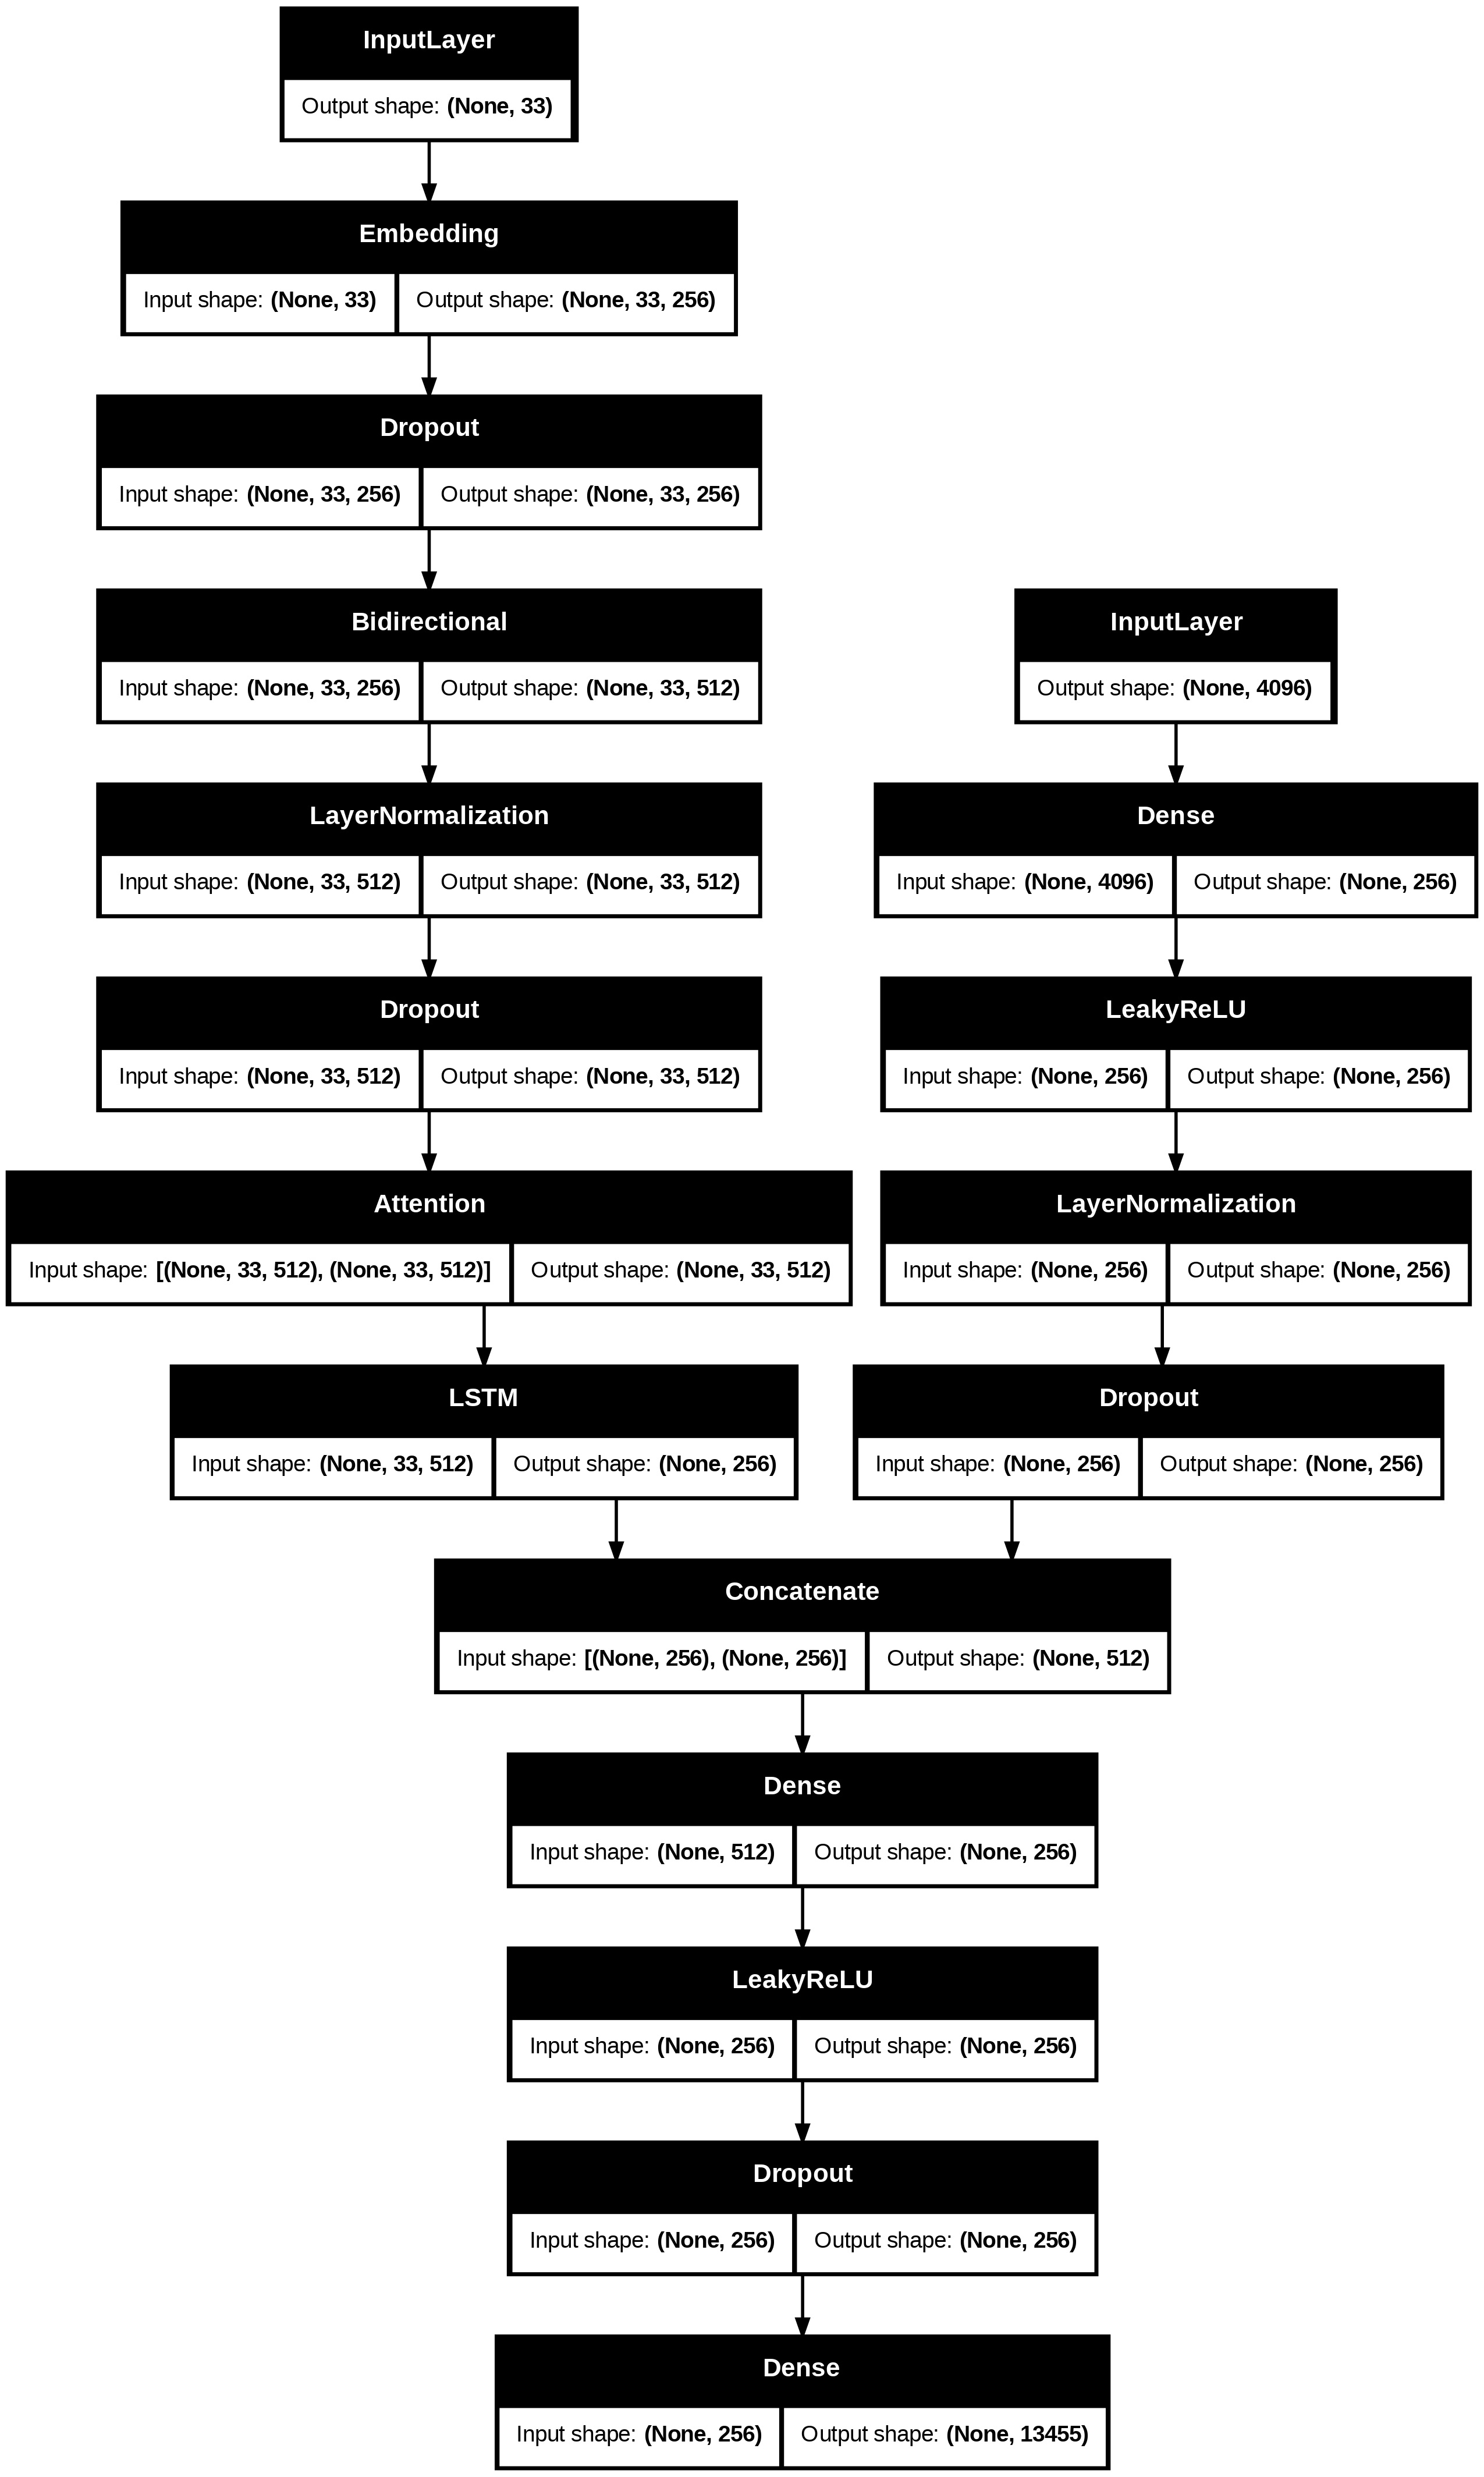

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

Training the Model

(Split dataset,Set loss function, optimizer, training loop, checkpoint saving.)

In [48]:
from sklearn.model_selection import train_test_split

# image IDs (keys)
image_ids = list(train_validate_image_caption.keys())

# 80% train, 20% validation split
train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)


In [49]:
batch_size = 32
train_generator = DataGenerator(
    image_ids=train_ids,
    captions_dict=cleaned_augmented_dict,
    features_dict=train_validate_features,
    tokenizer=tokenizer,
    max_len=max_len,
    vocab_size=vocab_len,
    batch_size=batch_size,
    shuffle=True
)

val_generator = DataGenerator(
    image_ids=val_ids,
    captions_dict=cleaned_augmented_dict,
    features_dict=train_validate_features,
    tokenizer=tokenizer,
    max_len=max_len,
    vocab_size=vocab_len,
    batch_size=batch_size,
    shuffle=False
)


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Save best model
checkpoint_callback = ModelCheckpoint(
    filepath='./best_model.keras',  # Use recommended Keras format
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Stop training if no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Allow more time before stopping
    verbose=1
)

# Reduce LR if val_loss stagnates
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,  # Increase patience
    min_lr=1e-5,  # Prevent LR from becoming too small
    verbose=1
)

# Log training process
csv_logger_callback = CSVLogger("training_log.csv", append=True)

#bleu_callback = BLEUCallback(val_data=val_generator, tokenizer=tokenizer, max_len=max_len)

# Final callback list
callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback, csv_logger_callback]


In [51]:
history=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 7.1876
Epoch 1: val_loss improved from inf to 5.73394, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 288s 1s/step - loss: 7.1839 - val_loss: 5.7339 - learning_rate: 0.0010
Epoch 2/40
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.6304
Epoch 2: val_loss improved from 5.73394 to 5.37151, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - loss: 5.6300 - val_loss: 5.3715 - learning_rate: 0.0010
Epoch 3/40
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.3140
Epoch 3: val_loss improved from 5.37151 to 5.23741, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - loss: 5.3140 - val_loss: 5.2374 - learning_rate: 0.0010
Epoch 4/40
202/202 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.1344
Epoch 4: val_loss improved from 5.23741 to 5.12587, saving model to ./best_model.keras
202/202 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - loss: 5.1345 - val_loss: 5.1259 - learning_rate:

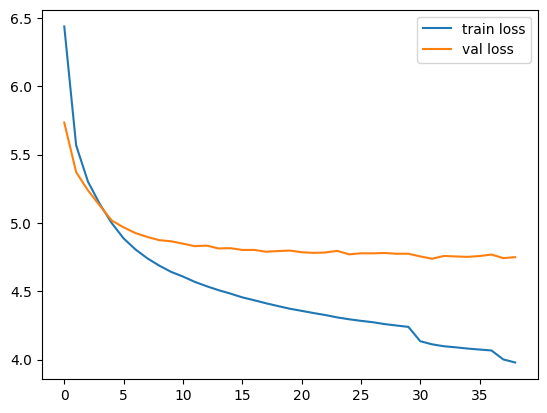

In [52]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [53]:
import json

# Let's assume these exist
tokenizer =tokenizer
max_len = max_len
vocab_size =vocab_len

# Save tokenizer itself
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save additional info
metadata = {
    "max_len": max_len,
    "vocab_size": vocab_size
}
with open("tokenizer_meta.json", "w") as f:
    json.dump(metadata, f)


In [9]:
import pickle
import json
# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load metadata
with open("tokenizer_meta.json", "r") as f:
    metadata = json.load(f)

max_len = metadata["max_len"]
vocab_len = metadata["vocab_size"]


In [11]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('./best_model.keras')

# Now you can use the best_model for prediction or further training
print(best_model.summary())


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  3,248,896 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 34, 512)   │  1,050,624 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 34, 512)   │      1,024 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256)       │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 34, 512)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 256)       │        512 │ leaky_re_lu[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 34, 512)   │          0 │ dropout_2[0][0],  │
│ (Attention)         │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 256)       │    787,456 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 12691)     │  3,261,587 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 28,590,779 (109.07 MB)

 Trainable params: 9,530,259 (36.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,060,520 (72.71 MB)

None


Evaluating the Model

(Calculate BLEU score, visualize results, plot graphs.)

In [10]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [12]:
def generate_description(model, tokenizer, photo, max_length, k=5, temperature=1.0, greedy_steps=1):
    def sample_with_temperature(preds, temperature):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + 1e-9) / temperature  # Avoid log(0)
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

    in_text = 'startseq'
    result = []

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model.predict([photo, sequence], verbose=0)[0]

        if i < greedy_steps:
            predicted_id = np.argmax(yhat)  # Greedy decoding
        else:
            # Top-k sampling with temperature
            top_k_indices = np.argsort(yhat)[-k:]
            top_k_probs = yhat[top_k_indices]
            predicted_id = top_k_indices[sample_with_temperature(top_k_probs, temperature)]

        word = word_for_id(predicted_id, tokenizer)
        if word is None:
            break

        in_text += ' ' + word
        result.append(word)

        if word == 'endseq':
            break

    return ' '.join(result[:-1] if result and result[-1] == 'endseq' else result)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_121']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8071: 3058439373_9276a4702a
📌 Predicted Captions:


  1. man is walking down street
  2. man with blue shirt stands on street with the people
  3. man with backpack walks down street

📋 Actual Captions:
  1. startseq crowd of people are standing in front of italian style buildings endseq
  2. startseq crowd of people stand looking at somthing in european courtyard endseq
  3. startseq crowd of people stands attentively in plaza with buildings in the background endseq
  4. startseq group of people are looking at the buildings endseq
  5. startseq of people standing in the town square looking up endseq

**********************************************************************



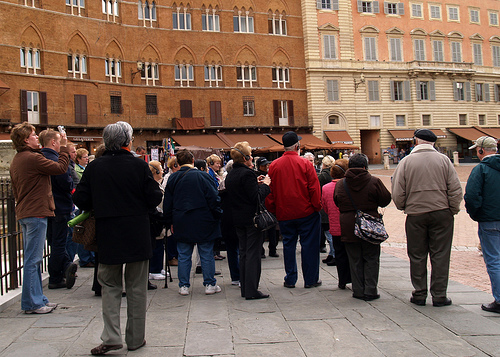

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_144']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8072: 2191453879_11dfe2ba3a
📌 Predicted Captions:
  1. man with blue shirt and black shorts running in field while others watch in the background
  2. man with black shirt running through the field
  3. man wearing white shirt is jumping to the ball with soccer ball

📋 Actual Captions:
  1. startseq boy running through grassy area in park endseq
  2. startseq boy with red shoes runs across field endseq
  3. startseq little boy in shorts and blue tshirt runs on the grass endseq
  4. startseq young boy running on field endseq
  5. startseq boy in blue shirt and gray shorts running at park endseq

**********************************************************************



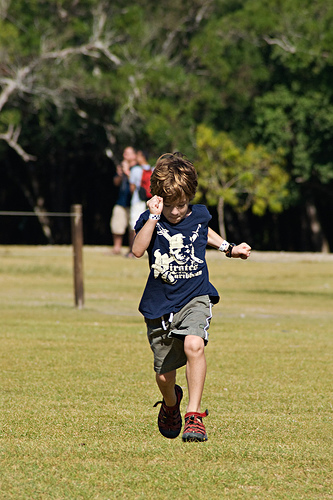

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_167']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8073: 3425887426_bf60b8afa3
📌 Predicted Captions:
  1. tennis player is holding ball
  2. tennis player in white shirt is playing tennis
  3. tennis player in yellow outfit and white headband and white gloves

📋 Actual Captions:
  1. startseq person holding tennis racket hits yellow tennis ball endseq
  2. startseq tennis player hitting the ball endseq
  3. startseq tennis player hitting the ball endseq
  4. startseq tennis ball is about to be hit endseq
  5. startseq man is hitting tennis ball with tennis racket endseq

**********************************************************************



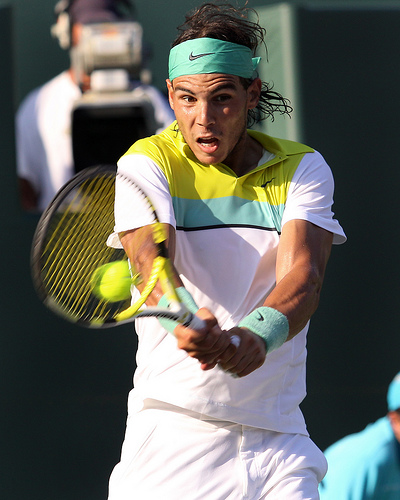

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_190']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8074: 3278189732_f750cb26b7
📌 Predicted Captions:
  1. dog is running in the grass
  2. dog is jumping into the air while jumping on the ground
  3. dog is running through the grass

📋 Actual Captions:
  1. startseq black and white dog jumping high to catch ball endseq
  2. startseq black and white dog leaping to catch an orange ball in an open field endseq
  3. startseq dog jumps to catch ball in grassy field endseq
  4. startseq dog leaps into the air for tennis ball endseq
  5. startseq and white dog is jumping into the air to catch ball outside endseq

**********************************************************************



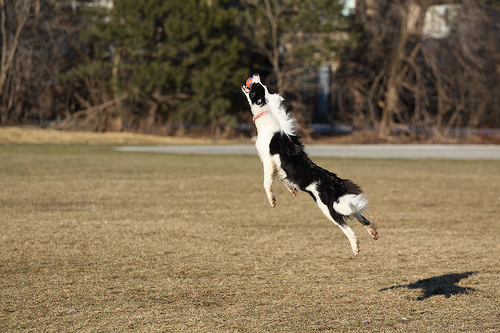

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_213']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8075: 2127207912_9298824e66
📌 Predicted Captions:
  1. man climbs rock rock
  2. man is scaling rock rock face in front of rock
  3. man in white climbs rock

📋 Actual Captions:
  1. startseq two people are standing on rock holding themselves up against another rock while looking down endseq
  2. startseq people make their way through rocky terrain endseq
  3. startseq people participate in rock climbing endseq
  4. startseq female hikers hang onto rock in front of them while looking down into deep crevice endseq
  5. startseq people wearing backpacks and woman in red shorts are standing on some large rock formations endseq

**********************************************************************



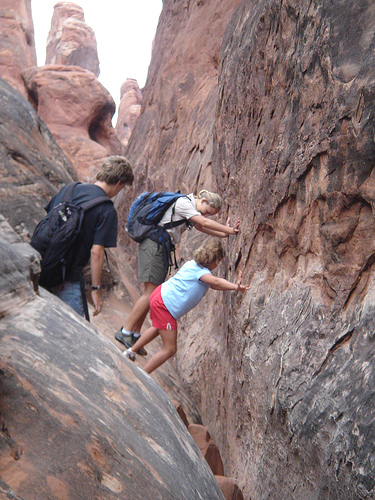

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_236']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8076: 1579287915_4257c54451
📌 Predicted Captions:
  1. man in blue shirt and backpack climbing rock
  2. man with red and white backpack is jumping over rock
  3. man in red shirt is standing on rock overlooking the mountains

📋 Actual Captions:
  1. startseq lone man stands on rocky outcropping and looks out over the wilderness endseq
  2. startseq man in shorts and black jacket stands on top of big rock looking down on hills and valleys endseq
  3. startseq man is standing on big rock overlooking valley endseq
  4. startseq man stands atop large mountain of rocks endseq
  5. startseq standing on edge of large rock overlooking scenic view endseq

**********************************************************************



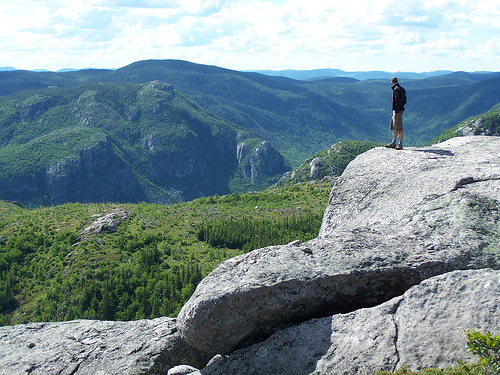

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_259']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8077: 2773011586_6f4cd41e84
📌 Predicted Captions:
  1. man is sitting on roller coaster with their arms in enjoyment on the top from the camera
  2. man in white shirt and white shirt is jumping over the boat
  3. man in yellow is jumping at the water in the air

📋 Actual Captions:
  1. startseq are riding on ride at theme park or carnival endseq
  2. startseq in the log ride throw their arms in the air in enjoyment as they prepare for the watery descent endseq
  3. startseq people are riding down log flume in theme park endseq
  4. startseq people raise up their arms in rollercoaster ride endseq
  5. startseq log amusement park ride with people in it at night endseq

**********************************************************************



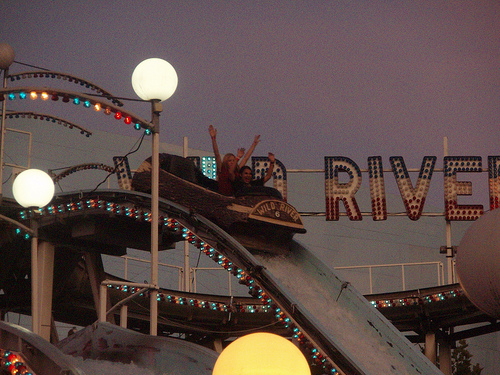

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_282']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8078: 3356901257_83811a19eb
📌 Predicted Captions:
  1. dog with the ball on his back is running in the water
  2. dog is jumping to catch stick
  3. dog is being ready to throw the water

📋 Actual Captions:
  1. startseq brown dog on the sand endseq
  2. startseq brown dog plays in the sand near man in green cap endseq
  3. startseq dog is jumping in the air to catch something endseq
  4. startseq dog is jumping up for the ball while playing catch in the sand endseq
  5. startseq dog playing ball in the sand endseq

**********************************************************************



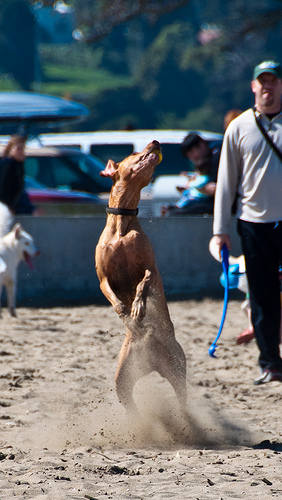

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_305']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8079: 3016521240_2ef20834b6
📌 Predicted Captions:
  1. girl with purple shirt is wearing white pink dress
  2. girl in purple shirt has her head on the bed
  3. girl and man in costume is sitting in front of the camera

📋 Actual Captions:
  1. startseq girl holds blowup tiger while another girl is in costume endseq
  2. startseq girl sits on bench holding an inflatable tiger next to another girl in colorful outfit endseq
  3. startseq sit in costumes endseq
  4. startseq girl wearing black is holding toy and is sitting next to girl in costume endseq
  5. startseq women sitting on bench their faces obscured with one woman carrying an inflatable tiger and the other woman in disney snow white costume endseq

**********************************************************************



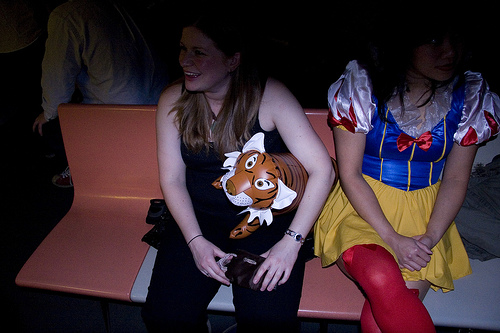

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_328']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Image 8080: 3092756650_557c5f2d03
📌 Predicted Captions:
  1. man and man with white hats are holding their heads in the street
  2. man with black hat in front of man and woman and white in the distance
  3. man with hat in white hat is holding sign in his

📋 Actual Captions:
  1. startseq group of indian men are just standing around with their arms crossed endseq
  2. startseq group of men stand outside endseq
  3. startseq men from another country look at the camera endseq
  4. startseq wearing hats stand with arms folded endseq
  5. startseq men wearing ethnic hats are watching the photographer in an outdoor market endseq

**********************************************************************



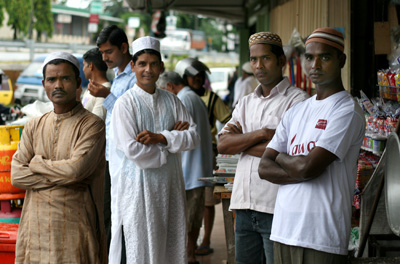

In [59]:
from IPython.display import Image, display
import os

for count in range(8070, 8080):
    image_id = caption_images_list[count]
    image_file_path = os.path.join(images_path, image_id + '.jpg')

    if os.path.exists(image_file_path):
        # Extract features
        photo = extract_feat(image_file_path)

        # Print the image ID
        print(f"Image {count+1}: {image_id}")

        # Generate and display 3 distinct captions
        print("📌 Predicted Captions:")
        for i in range(3):  # Generate 3 captions
            description = generate_description(best_model, tokenizer, photo, max_len)
            print(f"  {i+1}. {description}")

        print("\n📋 Actual Captions:")

        # Display actual captions
        for i, actual in enumerate(new_captions_dict[image_id]):
            print(f"  {i+1}. {actual}")

        print('\n' + '*' * 70 + '\n')

        # Display the image after captions
        display(Image(filename=image_file_path))

    else:
        print(f"❌ Image file not found: {image_file_path}")


In [13]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_bleu(references, predictions):
    # Convert references and predictions to the correct format for BLEU
    references = [[ref.split()] for ref in references]  # List of references per image
    predictions = [pred.split() for pred in predictions]  # List of predicted captions

    return corpus_bleu(references, predictions)


In [61]:
references = list(cleaned_augmented_dict.values())[:10]
predictions = []
for i in range(10):
    image_id = caption_images_list[i]
    image_file_path = os.path.join(images_path, image_id + '.jpg') # grab the image full path
    photo = extract_feat(image_file_path) # extract image features
    description = generate_description(best_model, tokenizer, photo, max_len) # generate description
    predictions.append(description)  # store prediction

bleu_score = corpus_bleu(references, predictions) # pass list of references vs list of predictions
print(f"BLEU score: {bleu_score}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_351']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_374']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_397']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_420']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warning

BLEU score: 0.34431014521300357


In [14]:
references = list(new_captions_dict.values())[8071:8081]
predictions = []
for i in range(8071,8081):
    image_id = caption_images_list[i]
    image_file_path = os.path.join(images_path, image_id + '.jpg') # grab the image full path
    photo = extract_feat(image_file_path) # extract image features
    description = generate_description(best_model, tokenizer, photo, max_len) # generate description
    predictions.append(description)  # store prediction

bleu_score = corpus_bleu(references, predictions) # pass list of references vs list of predictions
print(f"BLEU score: {bleu_score}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_34']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_57']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_80']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_103']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.w

BLEU score: 0.36187665200006347
